In [7]:
import pandas as pd
from pathlib import Path

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline

from imblearn import over_sampling as ovs
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.externals import joblib
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

%matplotlib inline

In [8]:
sns.set_context(context="paper")
def plot_test_reg(y_true,y_pred):
    from matplotlib.offsetbox import AnchoredText

    rmse_test = np.round(np.sqrt(mean_squared_error(y_true, y_pred)), 3)
    df_pred = pd.DataFrame({"Predicted ddG(kcal/mol)": y_pred, "Actual ddG(kcal/mol)": y_true})
    
    pearsonr_test = round(df_pred.corr().iloc[0,1],3)
    
    g = sns.regplot(x="Actual ddG(kcal/mol)", y="Predicted ddG(kcal/mol)",data=df_pred)
    
    plt.title("Predicted vs Experimental ddG (Test set: %s complexes)"%y_true.shape[0])
    anchored_text1 = AnchoredText("pearsonr = %s" %pearsonr_test, loc=1)
    anchored_text2 = AnchoredText("RMSE = %s" %rmse_test, loc=4)

    g.add_artist(anchored_text1)
    g.add_artist(anchored_text2)
    
from sklearn.model_selection import learning_curve
def learning_curves(estimator, features, target, cv):
    train_sizes, train_scores, validation_scores = learning_curve(
                                                 estimator, features, target,train_sizes = np.linspace(.1, 1.0, 10),
                                                 cv = cv, scoring = 'neg_mean_squared_error',n_jobs=-1)
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)
    
    plt.plot(train_sizes, np.sqrt(train_scores_mean), label = 'Training error')
    plt.plot(train_sizes, np.sqrt(validation_scores_mean), label = 'Validation error')

    plt.ylabel('RMSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curve'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(0,3)

In [9]:
ABPRED_DIR = Path().cwd().parent
DATA = ABPRED_DIR / "data"

#dataframe final
df_final = pd.read_csv(DATA/"../data/DF_features_400_2019.csv",index_col=0)
# Quitar modelos por homologia deltraining set
#df_final_onlyHM = df_final.loc[df_final.index.str.startswith("HM")]
#df_final= df_final.loc[~df_final.index.str.startswith("HM")]

index_ddg8 = (df_final['ddG(kcal/mol)']==8)
df_final = df_final.loc[-index_ddg8]
#testiar eliminando estructuras con ddg menor o igual a -4 kcal/mol , outliers
index_ddg_4 =  (df_final['ddG(kcal/mol)'] <= -4)
df_final = df_final.loc[-index_ddg_4]


pdb_names = df_final.index
features_names = df_final.drop('ddG(kcal/mol)',axis=1).columns


In [10]:
import math
def deltaG_to_Kd(delg):
    Kd_value = math.exp((delg*1000)/(1.98*298.15))
    return Kd_value

In [11]:
#X = df_final_f1 # con filtrado de varianza
X = df_final.drop('ddG(kcal/mol)',axis=1)
y = df_final['ddG(kcal/mol)']

In [12]:
#y_pKd = -y.apply(deltaG_to_Kd).apply(math.log10)
#y = y_pKd

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.8,random_state=12)
                                                    

/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


max_depth=7 ,  min_samples_leaf=1, min_samples_split=2,

In [11]:
#1)
scaler = StandardScaler()
#2)
rfr = RandomForestRegressor()

#3) Crear pipeline
pipeline1 = make_pipeline(scaler ,rfr)


# Create the parameter grid based on the results of random search 
param_grid = {
    'randomforestregressor__bootstrap': [True],
    'randomforestregressor__max_depth': [2,5,15,25,30,None],
    'randomforestregressor__max_features': ["log2","sqrt","auto"],
    'randomforestregressor__max_leaf_nodes':[50,60,70,80,90],
    'randomforestregressor__min_samples_leaf': [1, 2, 5],
    'randomforestregressor__min_samples_split': [2,5,10,15],
    'randomforestregressor__n_estimators': [100,300,500,1000],
    'randomforestregressor__random_state':[1],
    }

grid1 = GridSearchCV(pipeline1,param_grid, verbose=1,scoring="neg_mean_squared_error",cv=10,n_jobs=-1)
# fit
grid1.fit(X_train, y_train)

print(grid1.best_params_)
print('Training score (r2): {}'.format(grid1.best_estimator_.score(X_train, y_train)))
print('Test score (r2): {}'.format(grid1.best_estimator_.score(X_test, y_test)))

y_pred = grid1.best_estimator_.predict(X_test)
print("\nRoot mean square error for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)))
print("pearson corr:\n",np.corrcoef(y_pred,y_test)[0][1])

Fitting 10 folds for each of 4320 candidates, totalling 43200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 6018 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 8418 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 9768 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 11218 tasks      

{'randomforestregressor__bootstrap': True, 'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__max_leaf_nodes': 90, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 500, 'randomforestregressor__random_state': 1}
Training score (r2): 0.797114499568453
Test score (r2): 0.37997800072582977

Root mean square error for test dataset: 1.02
pearson corr:
 0.6193646566691169


/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


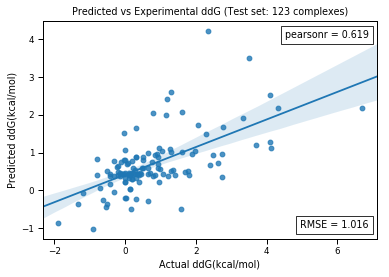

In [18]:
plot_test_reg(y_pred=y_pred,y_true=y_test)

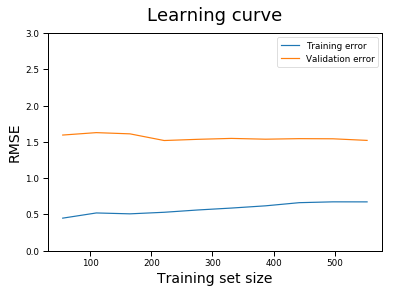

In [19]:
learning_curves(grid1.best_estimator_,X,y,10)


# Apply SMOTE, only on train data, and test only one with best parameters 


In [137]:
# forma 1
df_final['class'] = np.where((df_final['ddG(kcal/mol)'] < -1) | (df_final['ddG(kcal/mol)'] > 3.0),1,0)
# forma 2 
#df_final['class'] = np.where((df_final['ddG(kcal/mol)'] < 0),1,0)

In [138]:
print("Before OverSampling, counts of label '1': {}".format(sum(df_final['class'] == 1)))
print("Before OverSampling, counts of label '0': {}".format(sum(df_final['class'] == 0)))

Before OverSampling, counts of label '1': 65
Before OverSampling, counts of label '0': 550


In [139]:
X = df_final.drop('class',axis=1)
y = df_final['class']

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify = y,train_size=0.7,random_state=12)


/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [141]:
#smote = ovs.SMOTE(random_state=12)
#smote = ovs.BorderlineSMOTE(random_state=12)
adasyn = ovs.ADASYN(random_state=12,n_neighbors=5)
X_train_re , y_train_re = adasyn.fit_sample(X_train,y_train)
#X_train_re , y_train_re = smote.fit_sample(X_train,y_train)

In [142]:
# back to originalk shape and target
X_train_normal = X_train_re[:,:-1]
y_train_normal = X_train_re[:,-1]

X_test_normal = X_test.iloc[:,:-1]
y_test_normal = X_test.iloc[:,-1]

In [181]:
#1)
scaler = StandardScaler()
#2)
rfr = RandomForestRegressor(bootstrap=True, max_depth=None,max_features='sqrt',max_leaf_nodes=90,
                            min_samples_leaf=1,min_samples_split=2, n_estimators=500,random_state=1)
#3) Crear pipeline
pipe = make_pipeline(scaler ,rfr)
pipe.fit(X_train_normal,y_train_normal)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=90,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False))])

In [182]:
print('Training score (r2): {}'.format(pipe.score(X_train_normal, y_train_normal)))
print('Test score (r2): {}'.format(pipe.score(X_test_normal, y_test_normal)))

y_test_pred = pipe.predict(X_test_normal)
y_train_pred = pipe.predict(X_train_normal)
print("\nRoot mean square error for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train_normal, y_train_pred)), 2)))

print("\nRoot mean square error for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test_normal, y_test_pred)), 2)))
print("pearson corr:\n",np.corrcoef(y_test_pred,y_test_normal)[0][1])

Training score (r2): 0.932990012818977
Test score (r2): 0.436266432720505

Root mean square error for train dataset: 0.56

Root mean square error for test dataset: 1.11
pearson corr:
 0.6678987303448616


/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


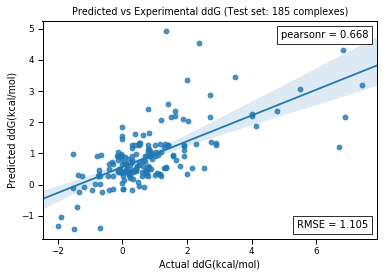

In [183]:
plot_test_reg(y_pred=y_test_pred,y_true=y_test_normal)


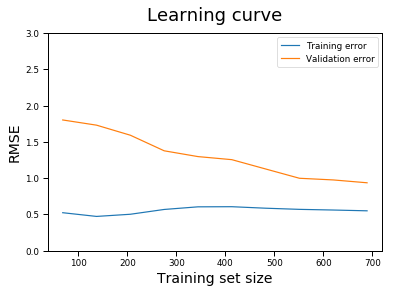

In [184]:
learning_curves(pipe,X_train_normal,y_train_normal,10)


In [9]:
grid_search.fit(X_train, y_train)

model = grid_search.best_estimator_

model.fit(X_train, y_train)

joblib.dump(model, '../../../../GDrive/RFmodel_400.10cv.v4.pkl')

Fitting 10 folds for each of 6048 candidates, totalling 60480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 6018 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 8418 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 9768 tasks      | elapsed: 26.4min
[Parallel(n_jobs=-1)]: Done 11218 tasks      

KeyboardInterrupt: 

In [11]:
f = open("rf_models400F_Fullsearch.txt","a")
print(grid_search.best_estimator_)
f.write('10 fold\n'+str(grid_search.best_estimator_))
print('\nBest GridSearchCV Score 5fold : ' + str(-grid_search.best_score_))

model = grid_search.best_estimator_

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

#print("OOB Score : " + str(model.oob_score_)) # yg diitung r2 score
print('Train MSE : ' + str(mean_squared_error(y_train, y_pred_train)))
print('Train MAE : ' + str(mean_absolute_error(y_train, y_pred_train)))
print('Train R^2 : ' + str(r2_score(y_train, y_pred_train)))

print('Test R^2 : ' + str(r2_score(y_test, y_pred_test)))
print('Test MSE : ' + str(mean_squared_error(y_test, y_pred_test)))
print('Test MAE : ' + str(mean_absolute_error(y_test, y_pred_test)))

print("\nRoot mean square error for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_pred_test)), 2)))
print("pearson corr:\n",np.corrcoef(y_pred_test,y_test)[0][1])

f.write('\nTrain MSE : ' + str(mean_squared_error(y_train, y_pred_train)))
f.write('\nTrain MAE : ' + str(mean_absolute_error(y_train, y_pred_train)))
f.write('\nTrain R^2 : ' + str(r2_score(y_train, y_pred_train)))
f.write('\nTest R^2 : ' + str(r2_score(y_test, y_pred_test)))
f.write('\nTest MSE : ' + str(mean_squared_error(y_test, y_pred_test)))
f.write('\nTest MAE : ' + str(mean_absolute_error(y_test, y_pred_test)))

f.write("\nRoot mean square error for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_pred_test)), 2)))
f.write("\npearson corr:\n"+str(np.corrcoef(y_pred_test,y_test)))
f.close()


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=70,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

Best GridSearchCV Score 5fold : 1.3148955090418302
Train MSE : 0.5178343892512987
Train MAE : 0.5567267413260787
Train R^2 : 0.7635667785591401
Test R^2 : 0.37950733046138563
Test MSE : 1.0339530157128027
Test MAE : 0.7293166147482881

Root mean square error for test dataset: 1.02
pearson corr:
 0.6189724898251511


## Salvar modelo final, entrenado con el total de lso datos

In [11]:
# save final model
final_model = grid_search.best_estimator_

final_model.fit(X,y)
joblib.dump(final_model, 'RFmodel_400.v2.pkl')


['RFmodel_400.v1.pkl']

/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(4.5,-0.5,'RMSE = 1.017')

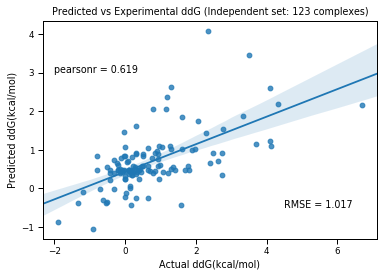

In [12]:
rmse_test = np.round(np.sqrt(mean_squared_error(y_test, y_pred_test)), 3)
df_pred = pd.DataFrame({"Predicted ddG(kcal/mol)": y_pred_test, "Actual ddG(kcal/mol)": y_test.values})
pearsonr_test = round(df_pred.corr().iloc[0,1],3)

g = sns.regplot(x="Actual ddG(kcal/mol)", y="Predicted ddG(kcal/mol)",data=df_pred)
plt.title("Predicted vs Experimental ddG (Independent set: 123 complexes)")

plt.text(-2,3,"pearsonr = %s" %pearsonr_test)
plt.text(4.5,-0.5,"RMSE = %s" %rmse_test)

#plt.savefig("RFmodel_300_testfit.png",dpi=600)

/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Predicted vs Experimental ddG (Train set: 492 complexes)')

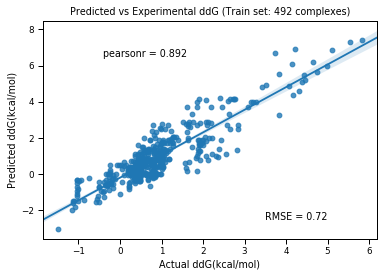

In [13]:
df_train_pred = pd.DataFrame({"Predicted ddG(kcal/mol)": y_train, "Actual ddG(kcal/mol)": y_pred_train})
pearsonr_train = round(df_train_pred.corr().iloc[0,1],3)
rmse_train = np.round(np.sqrt(mean_squared_error(y_train, y_pred_train)), 3)

g = sns.regplot(x="Actual ddG(kcal/mol)", y="Predicted ddG(kcal/mol)",data=df_train_pred)

plt.text(-0.4,6.5,"pearsonr = %s" %pearsonr_train)
plt.text(3.5,-2.5,"RMSE = %s" %rmse_train)
plt.title("Predicted vs Experimental ddG (Train set: 492 complexes)")
#plt.savefig("RFmodel_300_trainfit.png",dpi=600)


In [14]:
importances = list(model.feature_importances_)
feature_list = df_final.columns
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: Y_W                  Importance: 0.0338
Variable: A_Y                  Importance: 0.0297
Variable: A_S                  Importance: 0.026
Variable: N_R                  Importance: 0.0201
Variable: N_K                  Importance: 0.0181
Variable: S_D                  Importance: 0.0179
Variable: S_L                  Importance: 0.0178
Variable: D_K                  Importance: 0.0175
Variable: Y_R                  Importance: 0.0159
Variable: Y_S                  Importance: 0.0157
Variable: Y_K                  Importance: 0.0156
Variable: G_L                  Importance: 0.0147
Variable: W_K                  Importance: 0.0142
Variable: A_D                  Importance: 0.0141
Variable: Y_N                  Importance: 0.0138
Variable: R_A                  Importance: 0.0137
Variable: Y_A                  Importance: 0.0135
Variable: N_H                  Importance: 0.0132
Variable: E_K                  Importance: 0.0131
Variable: Y_L                  Importance: 0.013
Va

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

Text(0.5, 0, 'Feature importance')

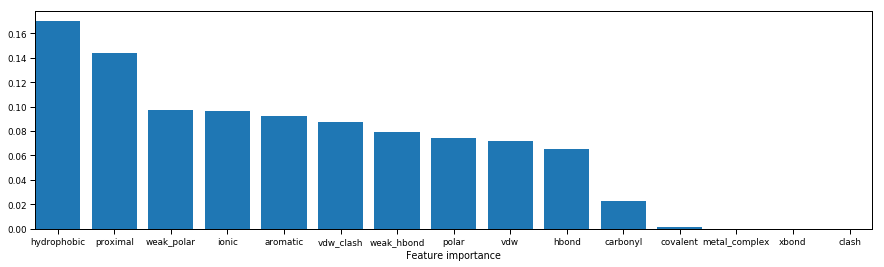

In [23]:
idx_features = model.feature_importances_.argsort()[::-1]
plt.figure(figsize=(15,4))

plt.bar(np.arange(X_train.shape[1]), model.feature_importances_[idx_features])
plt.xticks(range(len(feature_list)),feature_list[idx_features])
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel(u"Feature importance")
#plt.savefig("RFmodel_300_50features",dpi=600,bbox_inches="tight")

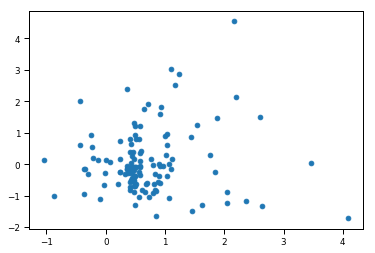

In [15]:
residual = y_test.values - y_pred_test
plt.scatter(x=y_pred_test.T, y=residual.T)

In [16]:
from sklearn.model_selection import learning_curve
def learning_curves(estimator, features, target, cv):
    train_sizes, train_scores, validation_scores = learning_curve(
                                                 estimator, features, target,train_sizes = np.linspace(.1, 1.0, 10),
                                                 cv = cv, scoring = 'neg_mean_squared_error',n_jobs=-1)
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)
    
    plt.plot(train_sizes, np.sqrt(train_scores_mean), label = 'Training error')
    plt.plot(train_sizes, np.sqrt(validation_scores_mean), label = 'Validation error')

    plt.ylabel('RMSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curve'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(0,3)

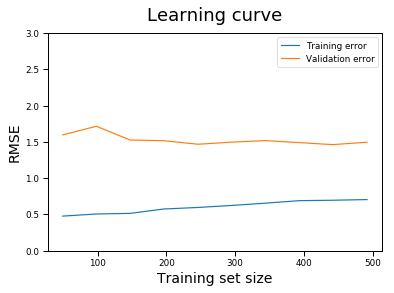

In [17]:
learning_curves(model,X,y,5)
#plt.savefig("RFmodel_300_learnincurve.png",dpi=600,bbox_inches="tight")

In [29]:
blind_test_mCSM = pd.read_csv("../benchmark/mCSM-AB-blind_test.predictions.csv",sep="\t")
blind_test_toCompare =blind_test_mCSM.loc[blind_test_mCSM["Type"]=="Forward"]

In [30]:
blind_test_toCompare

,PDB,Type,Mutation,Chain,DDG,PRED
0,HM_1KTZ,Forward,D118A,B,-0.80,-1.017
1,HM_1KTZ,Forward,D32A,B,-1.50,-1.197
2,HM_1KTZ,Forward,D32N,B,-2.00,-0.990
3,HM_1KTZ,Forward,E119A,B,-1.50,-1.183
4,HM_1KTZ,Forward,E119Q,B,-1.60,-0.620
5,HM_1KTZ,Forward,E55A,B,-1.20,-0.959
6,HM_1KTZ,Forward,E75A,B,-1.10,-0.684
7,HM_1KTZ,Forward,F110A,B,-0.90,-0.895
8,HM_1KTZ,Forward,F30A,B,-3.00,-1.745
9,HM_1KTZ,Forward,H79A,B,-0.30,-0.230


In [41]:
df_final.describe()

,clash,covalent,vdw_clash,vdw,proximal,hbond,weak_hbond,xbond,ionic,metal_complex,aromatic,hydrophobic,carbonyl,polar,weak_polar,ddG(kcal/mol)
count,615.0,615.000000,615.00000,615.000000,615.000000,615.000000,615.000000,615.0,615.000000,615.0,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000
mean,0.0,0.009756,16.75935,9.045528,514.852033,10.613008,6.752846,0.0,3.552846,0.0,7.074797,30.367480,0.573984,15.289431,10.804878,0.862211
std,0.0,0.098370,7.23212,5.271570,140.535258,4.165528,2.877644,0.0,3.431515,0.0,5.935670,11.133843,0.599109,5.859995,4.982475,1.446213
min,0.0,0.000000,5.00000,1.000000,216.000000,3.000000,1.000000,0.0,0.000000,0.0,0.000000,7.000000,0.000000,5.000000,2.000000,-3.000000
25%,0.0,0.000000,11.00000,4.500000,417.500000,8.000000,5.000000,0.0,0.000000,0.0,2.000000,20.000000,0.000000,11.000000,6.500000,-0.000000
50%,0.0,0.000000,14.00000,8.000000,514.000000,10.000000,7.000000,0.0,2.000000,0.0,8.000000,30.000000,1.000000,14.000000,11.000000,0.500000
75%,0.0,0.000000,21.00000,14.000000,621.000000,13.000000,8.000000,0.0,6.000000,0.0,10.000000,41.000000,1.000000,18.000000,15.000000,1.360000
max,0.0,1.000000,43.00000,24.000000,837.000000,21.000000,16.000000,0.0,12.000000,0.0,26.000000,55.000000,3.000000,30.000000,26.000000,7.420000


In [31]:
X_onlyHM, y_onlyHM = df_final_onlyHM.drop("ddG(kcal/mol)",axis=1),df_final_onlyHM["ddG(kcal/mol)"]

NameError: name 'df_final_onlyHM' is not defined

In [115]:
X_onlyHM_f1 = sel.transform(X_onlyHM)

In [117]:
y_onlyHM_pred = model.predict(X_onlyHM_f1)

In [119]:
blind_test_toCompare.loc[:,["DDG","PRED"]].corr()

,DDG,PRED
DDG,1.000000,0.232721
PRED,0.232721,1.000000


In [54]:
y_onlyHM_predicted = model.predict(X_onlyHM)

In [120]:
np.corrcoef([y_onlyHM_pred,y_onlyHM])

array([[ 1.        , -0.22890121],
       [-0.22890121,  1.        ]])